In [215]:
images_path = "DRIVE/image"
masks_path = "DRIVE/mask"

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



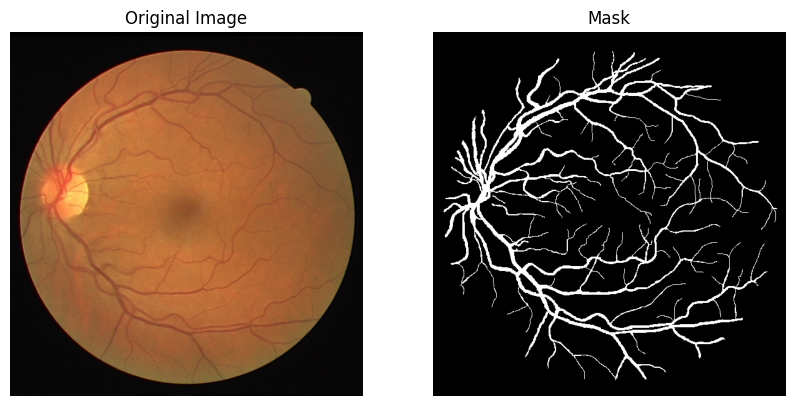

In [216]:
images = []
masks = []
for i in range(len(os.listdir(images_path))):
    image_name = f"{i+1}.tif"
    mask_name = f"{i+1}.png"
    image = plt.imread(os.path.join(images_path, image_name))
    mask = plt.imread(os.path.join(masks_path, mask_name))
    mask=np.where(mask>0,1,0)
    # binarize the mask
    images.append(image)
    masks.append(mask)
    

# Display the first image and its corresponding mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[0])
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(masks[0], cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.show()

In [217]:
def histo_equalized_batch(imgs):
    assert (len(imgs.shape) == 4)  # 4D arrays
    assert (imgs.shape[1] == 1)  # check the channel is 1
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i, 0] = cv2.equalizeHist(np.array(imgs[i, 0], dtype=np.uint8))
    return imgs_equalized


# CLAHE (Contrast Limited Adaptive Histogram Equalization)
# adaptive histogram equalization is used. In this, image is divided into small blocks called "tiles" (tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). If noise is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied
def clahe_equalized_batch(imgs):
    assert (len(imgs.shape) == 4)  # 4D arrays
    # assert (imgs.shape[1]==1)  #check the channel is 1
    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i, 0] = clahe.apply(np.array(imgs[i, 0], dtype=np.uint8))
    return imgs_equalized


# ===== normalize over the dataset
def dataset_normalized_batch(imgs):
    assert (len(imgs.shape) == 4)  # 4D arrays
    # assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs - imgs_mean) / imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (
                    np.max(imgs_normalized[i]) - np.min(imgs_normalized[i]))) * 255
    return imgs_normalized

def adjust_gamma_batch(imgs, gamma=1.0):
    assert (len(imgs.shape) == 4)  # 4D arrays
    # assert (imgs.shape[1]==1)  #check the channel is 1
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    new_imgs = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        new_imgs[i, 0] = cv2.LUT(np.array(imgs[i, 0], dtype=np.uint8), table)
    return new_imgs

def rgb2gray(rgb):
    assert (len(rgb.shape) == 4)  # 4D arrays
    assert (rgb.shape[1] == 3)
    bn_imgs = rgb[:, 1, :, :] * 0.75 + rgb[:, 2, :, :] * 0.25
    bn_imgs = np.reshape(bn_imgs, (rgb.shape[0], 1, rgb.shape[2], rgb.shape[3]))
    return bn_imgs

def preprocess_batch(data):
    assert (len(data.shape) == 4)
    assert (data.shape[1] == 3)  # Use the original images
    train_imgs = rgb2gray(data)
    # my preprocessing:
    train_imgs = dataset_normalized_batch(train_imgs)
    train_imgs = clahe_equalized_batch(train_imgs)
    train_imgs = adjust_gamma_batch(train_imgs, 1.2)
    return train_imgs

image_list=[]
for image in images:
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = image.transpose(0, 3, 1, 2)           # (1, 3, H, W)
    image = preprocess_batch(image)
    image_list.append(image)



(4000, 48, 48, 1) (4000, 48, 48, 1)


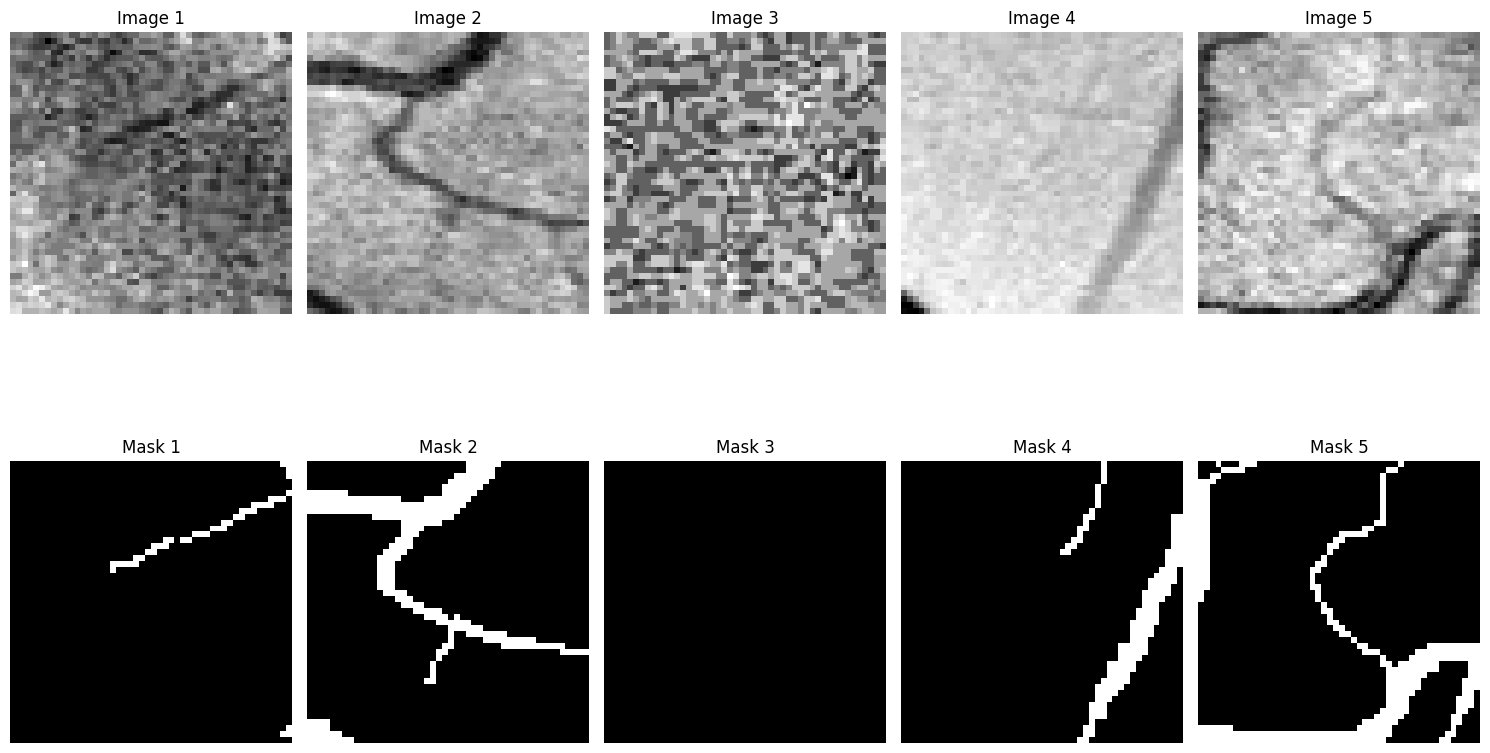

In [218]:
img_train_path = "train_images"
masks_train_path = "train_masks"

if not os.path.exists(img_train_path):
    os.makedirs(img_train_path)
if not os.path.exists(masks_train_path):
    os.makedirs(masks_train_path)


np.random.seed(42)  # For reproducibility
def make_imgs(images, masks, size=48, num_samples=100):
    patch_images, patch_masks = [], []
    for img, msk in zip(images, masks):
        # assume img shape = (1,1,H,W), msk shape = (H,W)
        H, W = img.shape[2], img.shape[3]
        for _ in range(num_samples):
            x = np.random.randint(0, W - size)
            y = np.random.randint(0, H - size)
            # grab a (48×48) slice directly
            patch = img[0, 0, y:y+size, x:x+size]     # → shape (48,48)
            mask  = msk[y:y+size, x:x+size]           # → shape (48,48)
            patch_images.append(patch)
            patch_masks.append(mask)
    return patch_images, patch_masks

patch_images, patch_masks = make_imgs(image_list, masks)

# stack into arrays for training:
X = np.stack(patch_images)      # (N,48,48)
Y = np.stack(patch_masks)       # (N,48,48)

# add channel axis for Keras:
X = X[..., np.newaxis]          # (N,48,48,1)
Y = Y[..., np.newaxis]          # (N,48,48,1)

# cast/scale:
X = X.astype('float32')/255.0
Y = Y.astype('float32')         # (0.0 or 1.0)

print(X.shape, Y.shape)
# → e.g. (2000, 48, 48, 1) , (2000, 48, 48, 1)

# when saving to disk, write them as plain 2D uint8:
for i, (img, mask) in enumerate(zip(patch_images, patch_masks)):
    cv2.imwrite(f"train_images/{i+1}.png", (img*255).astype(np.uint8))
    cv2.imwrite(f"train_masks/{i+1}.png", (mask*255).astype(np.uint8))

# show first 5 images and masks
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(patch_images[i], cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis("off")

    plt.subplot(2, 5, i + 6)
    plt.imshow(patch_masks[i], cmap='gray')
    plt.title(f"Mask {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [219]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    AveragePooling2D, Conv2D, BatchNormalization, Activation,
    LeakyReLU, MaxPool2D, UpSampling2D, Concatenate
)

# === constants ===
PATCH_SIZE = 48

# === 1) Linear transform for single‐channel input ===
class LinearTransform(tf.keras.Model):
    def __init__(self, name="LinearTransform"):
        super(LinearTransform, self).__init__(name=name)
        self.conv = Conv2D(1, kernel_size=3, strides=1, padding='same', use_bias=False)
        self.bn   = BatchNormalization()
        self.sig  = Activation('sigmoid')

    def call(self, x, training=True):
        c = self.conv(x)
        out = x * (1 + self.sig(c))
        return self.bn(out, training=training)


# === 2) Residual block ===
class ResBlock(tf.keras.Model):
    def __init__(self, out_ch, residual_path=False, stride=1):
        super(ResBlock, self).__init__()
        self.residual_path = residual_path

        self.conv1 = Conv2D(out_ch, 3, stride, padding='same', use_bias=False)
        self.bn1   = BatchNormalization()
        self.act1  = LeakyReLU()

        self.conv2 = Conv2D(out_ch, 3, 1, padding='same', use_bias=False)
        self.bn2   = BatchNormalization()

        if residual_path:
            self.conv_sc     = Conv2D(out_ch, 1, stride, padding='same', use_bias=False)
            self.bn_sc       = BatchNormalization()

        self.act2 = LeakyReLU()

    def call(self, x, training=True):
        y = self.act1(self.bn1(self.conv1(x), training=training))
        y = self.bn2(self.conv2(y), training=training)

        if self.residual_path:
            x = self.bn_sc(self.conv_sc(x), training=training)

        y = x + y
        return self.act2(y)


# === 3) Full U‐Net ===
class Unet(tf.keras.Model):
    def __init__(self):
        super(Unet, self).__init__()
        # encoder init
        self.conv_init    = LinearTransform()
        self.res_init     = ResBlock(16, residual_path=True)
        # first upsample to match your down‐path logic
        self.up_init      = UpSampling2D(2, interpolation='bilinear')
        self.res_up_init  = ResBlock(32, residual_path=True)

        # down‐path
        self.pool1        = MaxPool2D(2)
        self.rb1a         = ResBlock(64, residual_path=True)
        self.rb1b         = ResBlock(64)

        self.pool2        = MaxPool2D(2)
        self.rb2a         = ResBlock(128, residual_path=True)
        self.rb2b         = ResBlock(128)

        self.pool3        = MaxPool2D(2)
        self.rb3a         = ResBlock(256, residual_path=True)
        self.rb3b         = ResBlock(256)

        self.pool4        = MaxPool2D(2)
        self.rb4         = ResBlock(512, residual_path=True)

        # up‐path
        self.up3          = UpSampling2D(2, interpolation='bilinear')
        self.rb3c         = ResBlock(256, residual_path=True)
        self.rb3d         = ResBlock(256)

        self.up2          = UpSampling2D(2, interpolation='bilinear')
        self.rb2c         = ResBlock(128, residual_path=True)
        self.rb2d         = ResBlock(128)

        self.up1          = UpSampling2D(2, interpolation='bilinear')
        self.rb1c         = ResBlock(64, residual_path=True)

        self.up0          = UpSampling2D(2, interpolation='bilinear')
        self.rb0          = ResBlock(32, residual_path=True)

        # final bottleneck & output
        self.pool_final   = MaxPool2D(2)
        self.rb_final     = ResBlock(32)
        self.conv_final   = Conv2D(1, 1, padding='same', use_bias=False)
        self.bn_final     = BatchNormalization()
        self.act_final    = Activation('sigmoid')

    def call(self, x, training=True):
        # init
        x0 = self.conv_init(x, training=training)
        x1 = self.res_init(x0, training=training)
        x1 = self.up_init(x1)
        x1 = self.res_up_init(x1, training=training)

        # down 1
        d1 = self.pool1(x1)
        d1 = self.rb1a(d1, training=training)
        d1 = self.rb1b(d1, training=training)

        # down 2
        d2 = self.pool2(d1)
        d2 = self.rb2a(d2, training=training)
        d2 = self.rb2b(d2, training=training)

        # down 3
        d3 = self.pool3(d2)
        d3 = self.rb3a(d3, training=training)
        d3 = self.rb3b(d3, training=training)

        # down 4
        d4 = self.pool4(d3)
        d4 = self.rb4(d4, training=training)

        # up 3
        u3 = Concatenate()([d3, self.up3(d4)])
        u3 = self.rb3c(u3, training=training)
        u3 = self.rb3d(u3, training=training)

        # up 2
        u2 = Concatenate()([d2, self.up2(u3)])
        u2 = self.rb2c(u2, training=training)
        u2 = self.rb2d(u2, training=training)

        # up 1
        u1 = Concatenate()([d1, self.up1(u2)])
        u1 = self.rb1c(u1, training=training)

        # up 0 / final
        u0 = Concatenate()([x1, self.up0(u1)])
        u0 = self.rb0(u0, training=training)

        # bottleneck + output
        bf = self.pool_final(u0)
        bf = self.rb_final(bf, training=training)
        out = self.act_final(self.bn_final(self.conv_final(bf), training=training))

        return out





In [220]:

# hyperparams
EPOCHS     = 200
VAL_TIME   = 2
LR         = 3e-4
BATCH_SIZE = 64

INPUT_SHAPE = (None, 48, 48, 3)

X_train, X_val, Y_train, Y_val = train_test_split(patch_images, patch_masks, test_size=0.2, random_state=42)
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val   = np.array(X_val)
Y_val   = np.array(Y_val)
# === 4) Instantiate & compile ===
inputs = Input(shape=(PATCH_SIZE, PATCH_SIZE, 1), name="grayscale_patch")
outputs = Unet()(inputs)

model = Model(inputs, outputs, name="grayscale_unet")
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "grayscale_unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ grayscale_patch (InputLayer)    │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ unet_13 (Unet)                  │ (None, 48, 48, 1)      │    11,351,697 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,351,697 (43.30 MB)

 Trainable params: 11,339,309 (43.26 MB)

 Non-trainable params: 12,388 (48.39 KB)

In [221]:

from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam

# --- 1) hyperparams ---
EPOCHS     = 200
VAL_TIME   = 2
LR         = 3e-4
BATCH_SIZE = 64

PATCH_SIZE  = 48
INPUT_SHAPE = (PATCH_SIZE, PATCH_SIZE, 1)

# --- 2) prepare data ---
# assume `patch_images` is a list of H×W grayscale arrays and
#       `patch_masks`  is a list of binary H×W masks

# convert to float32, scale to [0,1]
X = np.array(patch_images, dtype='float32') / 255.0
Y = np.array(patch_masks,  dtype='float32') / 255.0

# add channel dimension
X = X.reshape(-1, PATCH_SIZE, PATCH_SIZE, 1)
Y = Y.reshape(-1, PATCH_SIZE, PATCH_SIZE, 1)

# train/val split
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=42
)

# --- 3) build & compile model ---
# (re-uses your Unet class from above)
inputs  = Input(shape=INPUT_SHAPE, name="grayscale_patch")
outputs = Unet()(inputs)

model = Model(inputs, outputs, name="grayscale_unet")
model.compile(
    optimizer=Adam(LR),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- 4) train ---
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_freq=VAL_TIME,
    shuffle=True
)


Model: "grayscale_unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ grayscale_patch (InputLayer)    │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ unet_14 (Unet)                  │ (None, 48, 48, 1)      │    11,351,697 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,351,697 (43.30 MB)

 Trainable params: 11,339,309 (43.26 MB)

 Non-trainable params: 12,388 (48.39 KB)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 285s 6s/step - accuracy: 0.3268 - loss: 0.7286
Epoch 2/200
 7/50 ━━━━━━━━━━━━━━━━━━━━ 4:03 6s/step - accuracy: 0.4361 - loss: 0.6962

KeyboardInterrupt: 